## <font color="blue">Interactivity</font>

<font color="blue">All cells are alterable but some cells that are easy to work with interactively are highlighted during the notebook. These are highlighted with the phrase **Alterable Cell** above them in blue and have instructions.</font>

<font color="blue">There is also a **DIY Section** towards the end of the Notebook that will allow you to modify parameters and use the code for your own purposes.</font>

<font color="blue">**Running Cells**</font>

- <font color="blue">To increase performance on the interactive graphics, click **Runtime** in the menu at the top of the Notebook, select **Change runtime type** and then click **T4 GPU**.</font>
- <font color="blue">To run all the cells, click **Runtime** in the menu at the top of the Notebook and select **Run All**.</font>
- <font color="blue">Shortcut to run a single cell, click in the cell and type **Ctrl + Enter (PC)** or **Cmnd + Enter (Mac)**.
- <font color="blue">If Notebook is not running correctly, try running all the cells again, as cells being run in the wrong order can sometimes cause issues.

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/parnell_files

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!pip install bertopic

In [ ]:
!pip install hvplot

In [ ]:
#disable unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
#enable interactive visualisations
%matplotlib notebook

In [2661]:
#libraries for working with files
import os
import glob
import requests
from pathlib import Path
from natsort import natsorted, os_sorted

#libraries for data extraction and parsing
from bs4 import BeautifulSoup

#libraries for data analysis and manipulation
import re
import string
import numpy as np
import pandas as pd
import geopandas
import collections
import networkx as nx
from datetime import datetime
from collections import Counter

#NLP Libraries
import spacy
from nltk.corpus import stopwords
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from bertopic import BERTopic

#libraries for visualization
import matplotlib.pyplot as plt
import mplcursors
import holoviews as hv
import hvplot.networkx as hvnx
import plotly.express as px
from shapely.geometry import box

# Optimize notebook and Spacy settings
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set DPI for Matplotlib figures
plt.rcParams['figure.dpi'] = 75

In [ ]:
def _render(self, **kw):
    """
    Rendering method for bokeh in Jupyter.
    Returns the rendered output as a MIMEBundle.
    """
    hv.extension('bokeh')
    return hv.Store.render(self)
hv.core.Dimensioned._repr_mimebundle_ = _render

### Data Extraction Functions

Functions which perform the various aspects of getting from a list of file paths through to extracting specific parts of each file.

In [2662]:
def soup_objects(file_paths):
    '''
    Takes either a list of file paths or a file path.
    Returns a list of beautiful soup objects or single
    beautiful soup object, depending on the input.
    '''
    if type(file_paths) == list:
        soup_list = []
        for path in file_paths:
            with path.open("r", encoding="utf-8") as xml:
                source = BeautifulSoup(xml, "lxml-xml")
                soup_list.append(source)
        return soup_list
    else:
        with file_paths.open("r", encoding="utf-8") as xml:
            soup_object = BeautifulSoup(xml, "lxml-xml")
        return soup_object

In [2663]:
def tei_extractor(soup_obj, element, attributes=False):
    '''
    Takes Beautiful soup object or list of objects,
    element using element name and, where necessary, attributes.
    Returns list of elements for all input files or a list of
    elements for input file, depending on input.
    '''
    attrib_dict ={}
    if attributes:
        attrib_dict = {attr: True for attr in attributes}

    if type(soup_obj) == list:
        elem_ls = [obj.find(element, attrib_dict) for obj in soup_obj]
        return elem_ls
    else:
        elem_ls = soup_obj.find_all(element, attrib_dict)
        return elem_ls

In [2664]:
def tei_values(object_list, attribute=False):
    '''
    Takes a list of beautiful soup elements, if attribute
    value is being extracted include name of that attribute.
    Return element or attribute value depending on input(s)
    '''
    if attribute:
        values = [obj[attribute] for obj in object_list]
        return values
    else:
        values = [obj.get_text() for obj in object_list]
        return values

### Data Cleaning and Dataframe Functions

Functions to perform text cleaning, remove stopwords, convert results into dataframe format and cleans dataframe format data.

In [2665]:
def text_cleaning(text):
    '''
    Takes as input a string, removes/replaces special characters, newlines,
    possessive apostrophes, hyphens, underscores, digits and makes single space.
    Keeps punctuation in place.
    Returns clean string.
    '''
    text = text.replace(u"\xa0", u" ").replace("&", "and").replace("|", " ")
    text = text.replace("\n", " ").replace("’", "'").replace("'s ", ' ')
    text = text.replace("-", " "). replace("–", " ").replace("_", " ").replace("—", " ")
    non_digit_text = re.sub(r"\b\d+\b", "", text)
    sing_space_text = re.sub(r"\s\s+", " ", non_digit_text)
    sing_space_text = sing_space_text.strip()
    return sing_space_text

In [2666]:
def punct_removal(text):
    '''
    Takes as input a string and removes punctuation, removes extra spacing.
    Returns string without punctuation.
    '''
    text = re.sub(r"(?<!\w)'|'(?!\w)", ' ', text)
    no_punc_text = re.sub(r"[^\w\s\']", ' ', text)
    sing_space_text = re.sub(r'\s+', ' ', no_punc_text).strip()
    return sing_space_text

In [2667]:
def remove_stopwords(text, stopwords):
    ''' 
    Take as input a string and list of stopwords, tokenizes
    string and removes words contained in stopwords.
    Returns re-joined string without stopwords.
    '''
    tokenized_text = text.split()
    non_stop_text = [token for token in tokenized_text if token not in stopwords]
    return ' '.join(non_stop_text)

In [2668]:
def create_dataframe(data, columns):
    '''
    Takes as input a list of lists of data and a list of columns.
    Returns a dataframe.
    '''
    df = pd.DataFrame(data)
    df = df.transpose()
    df.columns = columns
    return df

In [2669]:
def dataframe_cleaning(dataframe, clean_column=None):
    '''
    Takes as input a dataframe and makes lowercase, strips leading and
    trailing spaces, standardises apostrophes. Applies text_cleaning function
    to column if identified as clean column parameter.
    Returns lowercase/cleaned dataframe.
    '''
    lower_dataframe = dataframe.applymap(lambda x: x.lower())
    lower_dataframe = lower_dataframe.applymap(lambda x: x.replace("’", "'"))
    if clean_column:
        lower_dataframe[clean_column] = lower_dataframe[clean_column].apply(lambda x: text_cleaning(x))
    clean_dataframe = lower_dataframe.applymap(lambda x: x.strip())
    return clean_dataframe

In [2670]:
def dataframe_sentence_tokenize(dataframe, column, tokenizer):
    """
    Takes as input a dataframe containing a column of strings, name of a column
    to tokenize and a sentence tokenizer.
    Applies tokenizer to the column, creating a list of sentences in each row,
    uses explode to expand sentences, so each one has its own row.
    Changes name of column to 'sentence' and applies punctuation removal function
    now that column has been divided into sentences.
    Returns dataframe where each row contains a single sentence with punctuation removed.
    """
    dataframe[column] = dataframe[column].apply(lambda x: tokenizer.tokenize(x))
    sents_df = dataframe.explode(column)
    sents_df = sents_df.rename(columns={column:'sentence'})
    sents_df['sentence'] = sents_df['sentence'].apply(lambda x: punct_removal(x))
    return sents_df

### Data Filtering Functions

Functions to filter dataframe using different parameters.

In [2671]:
def dataframe_cooccurrance_count(dataframe, column, word):
    """
    Takes as input a dataframe containing a column of strings, name of column,
    and word to exclude from counts.
    Converts column contents into a list and uses Counter to find word
    frequency for all words in list, excluding word to exclude from count.
    Return sorted count list or empty list if input dataframe is empty.
    """
    if dataframe.empty:
        return []
    else:
        co_occur_words = ' '.join(dataframe[column]).split()
        word_count = Counter(co_occur_words)
        del word_count[word]
        sort_count = sorted(word_count.items(), key=lambda item: item[1], reverse=True)
    return sort_count

In [2672]:
def dataframe_count_strings(dataframe, column, keywords, word_boundary):
    """
    Takes as inputs dataframe, column name, keywords list and word boundary parameter.
    If column value or keywords incorrect or empty, raise ValueError.
    Counts occurrences of specified keywords in the given column of dataFrame.
    If word boundary is set to True ensures only whole word matches are counted.
    If word_boundary is set to False counts word as a substring as well.
    Returns a dictionary where the keys are the keywords and values their counts for the column.
    """
    if column not in dataframe.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    if not isinstance(keywords, list) or not keywords:
        raise ValueError("Keywords must be a non-empty list of strings.")
    
    processed_keywords = {word: fr"\b{re.escape(word)}\b" if word_boundary else re.escape(word) for word in keywords}
    word_counts = {}
    for word, word_pattern in processed_keywords.items():
        word_count = dataframe[column].str.findall(word_pattern, flags=re.IGNORECASE).str.len().sum()
        word_counts[word] = word_count
    return word_counts

In [2673]:
def filter_dataframe_by_keywords(dataframe, column, keywords, word_boundary=True, match_all=True):
    """
    Filters a DataFrame based on keywords list, with options for matching whole words or substrings,
    and for requiring all or any keywords to appear in each row.
    Takes dataframe and column name, searches column for regex matches depending on parameters below.
    - word_boundary: if True, only matches whole words. If False, matches substrings.
    - match_all: if True, only rows where all keywords are present are returned. 
    If False, rows with any keyword are returned.
    Returns filtered DataFrame.
    """
    if not keywords:
        return dataframe
    processed_keywords = [fr"\b{re.escape(word)}\b" if word_boundary else re.escape(word) for word in keywords]   
    pattern = "|".join(processed_keywords)
    if match_all:
        filtered_df = dataframe[dataframe[column].str.contains(pattern, case=False, regex=True)]
        filtered_df = filtered_df[
            filtered_df[column].apply(lambda text: all(re.search(word, text, flags=re.IGNORECASE) 
            for word in processed_keywords))
        ]
    else:
        filtered_df = dataframe[dataframe[column].str.contains(pattern, case=False, regex=True, na=False)]
    return filtered_df

In [2674]:
def filter_dataframe_by_keywords_exclude(dataframe, column, keywords, word_boundary=True, match_all=False):
    """
    Filters a DataFrame to exclude rows based on keywords list, 
    with options for matching whole words or substrings,
    and for requiring all or any keywords to appear in each row match.
    Takes dataframe and column name, searches column for regex matches depending on parameters below.
    - word_boundary: if True, only matches whole words. If False, matches substrings.
    - match_all: if True, only rows where all keywords are present are removed. 
    If False, rows with any keyword are removed.
    Returns filtered DataFrame.
    """
    if not keywords:
        return dataframe
    processed_keywords = [fr"\b{re.escape(word)}\b" if word_boundary else re.escape(word) for word in keywords]   
    pattern = "|".join(processed_keywords)
    if match_all:
        filtered_df = filtered_df[
            ~filtered_df[column].apply(lambda text: all(re.search(word, text, flags=re.IGNORECASE) 
            for word in processed_keywords))
        ]
    else:
        filtered_df = dataframe[~dataframe[column].str.contains(pattern, case=False, regex=True, na=False)]
    return filtered_df

In [2675]:
def dataframe_date_window(dataframe, column, include_range=None, exclude_range=None):
    """
    Takes as input a dataframe with a datetime column, column name, 
    a range for the date range to filter the dataframe by,
    and a date range to exclude during the filtering process.
    Creates masks for include_range and exclude_range if applicable,
    and applies them as dataframe filters.
    Returns filtered dataframe.
    """
    mask = pd.Series(True, index=dataframe.index)
    #range example: ['1880-01-01', '1885-01-01']
    if include_range:
        include_mask = (dataframe[column] >= include_range[0]) & (dataframe[column] <= include_range[1])
        mask &= include_mask 
    #range example: ['1890-01-01', '1890-12-31']
    if exclude_range:
        exclude_mask = ~((dataframe[column] >= exclude_range[0]) & (dataframe[column] <= exclude_range[1]))
        mask &= exclude_mask
    return dataframe.loc[mask]

In [2676]:
def dataframe_column_filter(dataframe, column, include_values=None, exclude_values=None):
    """
    Takes as input a dataframe with a string column, column name,
    a list of values to include during filtering process,
    and a list of values to exclude during filtering process.
    Creates masks for include_values and exclude_values if applicable,
    and applies them as dataframe filters.
    Filters dataframe based on substring matching in the given column.
    Returns filtered dataframe.
    """
    mask = pd.Series(True, index=dataframe.index)
    if include_values:
        include_pattern = '|'.join(include_values)  
        mask &= dataframe[column].str.contains(include_pattern, case=False, na=False)
    if exclude_values:
        exclude_pattern = '|'.join(exclude_values)
        mask &= ~dataframe[column].str.contains(exclude_pattern, case=False, na=False)
    return dataframe.loc[mask]

In [2677]:
def dataframe_apply_filters(dataframe, text_column, filters_dictionary, word_boundary, match_all,
                            exclude_word_boundary, exclude_match_all, text_filtering=True):
    """
    Apply multiple filters to a dataframe, taking as input a text column name, 
    filters dictionary, and text filtering parameters.
    If relevant key is found in filters dictionary, apply dataframe filtering
    with filtering function for the relevant category.
    Filtering is both for the inclusion and exclusion of rows.
    Return filtered dataframe.
    """
    filtered_df = dataframe.copy()
    if filters_dictionary["keywords"] and text_filtering:
        filtered_df = filter_dataframe_by_keywords(dataframe=filtered_df, column=text_column, 
                                                   keywords=filters_dictionary["keywords"], 
                                                   word_boundary=word_boundary, match_all=match_all)
        
    if filters_dictionary["not_keywords"] and text_filtering:
        filtered_df = filter_dataframe_by_keywords_exclude(dataframe=filtered_df, column=text_column, 
                                                           keywords=filters_dictionary["not_keywords"],  
                                                           word_boundary=exclude_word_boundary, match_all=exclude_match_all)
    
    if filters_dictionary["places"] or filters_dictionary["not_places"]:
        filtered_df = dataframe_column_filter(dataframe=filtered_df, column="place", 
                                            include_values=filters_dictionary["places"], 
                                            exclude_values=filters_dictionary["not_places"])

        
    if filters_dictionary["publications"] or filters_dictionary["not_publications"]:
        filtered_df = dataframe_column_filter(dataframe=filtered_df, column="publication", 
                                              include_values=filters_dictionary["publications"], 
                                              exclude_values=filters_dictionary["not_publications"])
        
    if filters_dictionary["include_range"] or filters_dictionary["exclude_range"]:
        filtered_df = dataframe_date_window(dataframe=filtered_df, column="date", 
                                            include_range=filters_dictionary["include_range"], 
                                            exclude_range=filters_dictionary["exclude_range"])
    
    return filtered_df

In [2678]:
def year_counts(dataframe):
    """
    Takes as input a dataframe, converts date column to year.
    Counts the different years present in dataframe.
    Returns a list where each tuple contains year, sentence count.
    """
    dataframe["year"] = dataframe["date"].dt.year
    year_counts = dataframe.groupby(["year"]).size()
    return list(year_counts.items())

### Visualisation Functions

Functions to produce visualisations.

In [2679]:
def bertopic_topics(dataframe, topic_model):
    """
    Takes as input a dataframe and Bertopic topic model tool.
    Extracts dates and sentences for each dataframe row as lists.
    Fits sentence list to topic model, creates dictionary of topics/sentences.
    Returns topics, topic/sentence dictionary and topic model.
    """
    sent_list = dataframe["sentence"].to_list()
    topics, probs = topic_model.fit_transform(sent_list)

    topic_docs = {topic: [] for topic in set(topics)}
    for topic, doc in zip(topics, sent_list):
        topic_docs[topic].append(doc)
    return (topics, topic_docs, topic_model)

In [2680]:
def bertopic_time(dataframe, topic_model):
    """
    Takes as input a dataframe and Bertopic topic model.
    Extracts dates and sentences for each dataframe row as lists.
    Sends sentence list/dates to topics_over_time provided by BERTopic 
    to create visualisation.
    Returns visualisation
    """
    sent_list = dataframe["sentence"].to_list()
    date_list = dataframe["date"].to_list()
    #parameters can be adjusted for visualisation
    topics_over_time = topic_model.topics_over_time(docs=sent_list,
                                                timestamps=date_list,
                                                nr_bins=30
                                              )
    fig = topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=15, height=500, width=1000)
    fig.update_layout(yaxis_title = "Count")
    return fig

In [2681]:
def frequency_visualisation(values, frequency, title):
    """
    Takes as input a list of values, a list of frequency scores,
    and a title string for a bar chart.
    Returns a Matplotlib bar chart representing
    value frequency, with title string as bar chart title.
    """
    x_pos = np.arange(len(values)) 
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.tight_layout(pad=2.0)
    ax.bar(x_pos, frequency)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(values, rotation=90)
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()

In [2682]:
def network_graph(edges, edge_weights=False, node_size_mult=15):
    """
    Takes list of lists of publication/location edges, returns a network graph 
    with node size changing depending on how many times node appears. Coloured 
    markers in graph depending on whether node contains comma (occuring in locations).
    If edge_weights is True, then edge thickness changes increases in proportion to
    the frequency of connections
    """
    #initialise network graph object
    G = nx.Graph()
    #flatten edges list of lists to get nodes
    nodes = [item for ls in edges for item in ls]
    #initialise counter object
    interactions = collections.Counter()
    #count the appearances of nodes
    for item in nodes:
        interactions[item] += 1
    #convert interactions to a dictionary
    interactions = dict(interactions)
    #create lists for node colours and sizes
    col_map = []
    size_list = []
    #loop through each node and number of appearances
    for key, value in interactions.items():
        #add each node to network graph
        G.add_node(key)
        #add value to list created above, made larger using size multiplier parameter
        size_list.append(value*node_size_mult)
        #give places and publications different colours and append colour to list created above
        if ',' in key:
            col_map.append('red')
        else:
            col_map.append('blue')
    #if edge_weights set to true, count each edge and convert to edge width
    if edge_weights:
        #use Counter to count the occurrences of each edge tuple
        edge_tups = [tuple(item) for item in edges]
        #count instances of each tuple
        edge_counts = collections.Counter(edge_tups)
        #convert the Counter object to a list of unique tuples with counts as a 'weight' dictionary at the end
        edges = [(t[0], t[1], {'weight': count}) for t, count in edge_counts.items()]
        #add edges to graph
        G.add_edges_from(edges)
        #get the edge weights as a dictionary
        edge_counts = nx.get_edge_attributes(G, 'weight')
        #create a list of edge widths based on the 'weight' attribute
        edge_widths = [edge_counts.get((u, v), 1) for u, v in G.edges]
        edge_widths = [value/2 for value in edge_widths]
    #if not edge_weights, just add edge tuples to graph with one edge width
    else:
        #add edges to graph
        G.add_edges_from(edges)
        #set all edge widths to 0.5
        edge_widths = 0.5
    #establish graph style and node positions
    pos = nx.spring_layout(G, k=0.1, iterations=20)
    #return visualisation using networkx graph object, size_list, colour_map,
    #labels, edge widths, width/height of image
    return hvnx.draw(G, pos, edge_cmap='viridis', node_size=size_list, node_color=col_map, edge_width=edge_widths, 
              width=1000, height=750)

## Extracting Data from Files

We begin by extracting the data we need from the speech report files and the speech register file.

In [2683]:
# get paths for speech reports
dir_path = Path('sources/')
#get filepaths to all the XML files in the directory
xml_files = (file for file in dir_path.iterdir() if file.is_file() and file.name.lower().endswith('.xml'))
#sort xml file paths numerically using os_sorted library
xml_files = os_sorted(xml_files)

#get path for speech register file
speech_file = Path('speeches/parnell_speeches.xml')

In [2684]:
#basename returns filename removing directory path.
#split to remove ".xml" extension so that we can use later as identifier
filenames = []
for path in xml_files:
    filename = os.path.basename(path)
    filename = filename.split(".")[0]
    filenames.append(filename)

In [2685]:
#extract speech reports and speech register as beautiful soup objects using function
report_objects = soup_objects(xml_files)
speech_object = soup_objects(speech_file)

In [2686]:
#speech register beautiful soup objects extracted as lists using function
#speech id, speech place and data
speech_id_objs = tei_extractor(speech_object, element='speech_id')
place_objs = tei_extractor(speech_object, element='place', attributes=['key'])
date_objs = tei_extractor(speech_object, element='date', attributes=['when'])

#speech reports beautiful soup objects extracted as lists using function
#speech id, publication name, text
speech_rep_objs = tei_extractor(report_objects, element='term', attributes=['key'])
publication_objs = tei_extractor(report_objects, element='title', attributes=['key', 'level'])
text_objs = tei_extractor(report_objects, element='body')

In [2687]:
#use function to extract values from tei elements extracted above
speech_ids = tei_values(speech_id_objs)
speech_places = tei_values(place_objs)
#if speech place returns blank convert to "unknown"
speech_places = ["unknown" if item == "" else item for item in speech_places]
speech_dates = tei_values(date_objs, attribute='when')

speech_rep_ids = tei_values(speech_rep_objs, attribute='key')
publications = tei_values(publication_objs)
#if publication returns blank convert to "unknown"
publications = ["unknown" if item == "" else item for item in publications]
texts = tei_values(text_objs)

#for speech ids, if more than one id present, shown by inclusion of comma, convert into a list
#some reports refer to more than one speech, so we need to capture them all 
speech_rep_ids = [item.split(',') if ',' in item else item for item in speech_rep_ids]

## Data Preparation

The next stage is to convert the speech data into a dataframe format where we can easily manipulate it and get different subsets prior to analysis/visualisation.

### Dataframes

Below we create different types of dataframe that will be used for different forms of analysis.

### Main Dataframe

Merges together speech report and speech register dataframes. The same report text will sometimes be repeated. This is the result of giving each speech id its own line in cases where a report covers more than one speech. This is necessary for forms of analysis where the speech id is important, but not for text-based analysis. Therefore, we create other dataframes below for text-based analysis.

In [2688]:
#prepare data for speech report dataframe, make list of lists of data and list of column names
speech_rep_data = [filenames, speech_rep_ids, publications, texts]
speech_rep_columns = ['filename', 'speech_id', 'publication', 'text']
#use function to turn the above lists into dataframe
speech_rep_df = create_dataframe(speech_rep_data, speech_rep_columns)
#if there is more than one speech id for a report, the report data will appear as row for each id
speech_rep_df = speech_rep_df.explode('speech_id')
#use function to clean the text in the dataframe and standardise it
speech_rep_df = dataframe_cleaning(speech_rep_df, clean_column='text')
speech_rep_df

,filename,speech_id,publication,text
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...
1,parnell_source_00002,speech_00001,the freeman's journal,the home rule league on saturday evening a pub...
2,parnell_source_00003,speech_00001,the nation,"the week ""though beaten, we are not vanquished..."
3,parnell_source_00004,speech_00001,the irish times,irish home rule league a public meeting of the...
4,parnell_source_00005,speech_00002,the freeman's journal,"mr. charles stewart parnell, in seconding the ..."
...,...,...,...,...
656,parnell_source_00660,speech_00396,the freeman's journal,"fellow countrymen and fellow citizens, it is n..."
657,parnell_source_00661,speech_00397,the freeman's journal,"mr. chairman, fellow citizens, and people of t..."
658,parnell_source_00662,speech_00398,the freeman's journal,"people of mallow, i certainly did not expect t..."
659,parnell_source_00663,speech_00399,the freeman's journal,"people of dungarvan, i will, through you, expr..."


In [2689]:
#prepare data for speech register dataframe, make list of lists of data and list of column names
speech_data = [speech_ids, speech_places, speech_dates]
speech_columns = ['speech_id', 'place', 'date']
#use function to turn the above lists into dataframe
speech_df = create_dataframe(speech_data, speech_columns)
#use function to clean the text in the dataframe and standardise it
speech_df = dataframe_cleaning(speech_df)
#make speech id index so we can use it when we merge dataframes below
speech_df.set_index('speech_id', inplace=True)
#convert date column to datetime format, enables us to manipulate dataframe using dates
speech_df['date'] = pd.to_datetime(speech_df['date'], format='%Y-%m-%d')
#drop empty rows
speech_df = speech_df.dropna(axis=0)
speech_df

,place,date
speech_id,,
speech_00001,"dublin, ireland",1874-07-11
speech_00002,"dublin, ireland",1875-01-21
speech_00003,"dublin, ireland",1875-01-22
speech_00004,"navan, ireland",1875-04-12
speech_00005,"london, england",1875-04-26
...,...,...
speech_00396,"cork, ireland",1881-10-02
speech_00397,"cork, ireland",1881-10-02
speech_00398,"mallow, ireland",1881-10-03


In [2690]:
#join the speech register and speech report dataframes indexing on speech_id
df_all = speech_rep_df.merge(speech_df, left_on='speech_id', right_index=True)
df_all

,filename,speech_id,publication,text,place,date
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...,"dublin, ireland",1874-07-11
1,parnell_source_00002,speech_00001,the freeman's journal,the home rule league on saturday evening a pub...,"dublin, ireland",1874-07-11
2,parnell_source_00003,speech_00001,the nation,"the week ""though beaten, we are not vanquished...","dublin, ireland",1874-07-11
3,parnell_source_00004,speech_00001,the irish times,irish home rule league a public meeting of the...,"dublin, ireland",1874-07-11
4,parnell_source_00005,speech_00002,the freeman's journal,"mr. charles stewart parnell, in seconding the ...","dublin, ireland",1875-01-21
...,...,...,...,...,...,...
656,parnell_source_00660,speech_00396,the freeman's journal,"fellow countrymen and fellow citizens, it is n...","cork, ireland",1881-10-02
657,parnell_source_00661,speech_00397,the freeman's journal,"mr. chairman, fellow citizens, and people of t...","cork, ireland",1881-10-02
658,parnell_source_00662,speech_00398,the freeman's journal,"people of mallow, i certainly did not expect t...","mallow, ireland",1881-10-03
659,parnell_source_00663,speech_00399,the freeman's journal,"people of dungarvan, i will, through you, expr...","dungarvan, ireland",1881-10-05


### Deduplicated Dataframe

This dataframe removes duplicate rows for the same report. These are created in the main dataframe because sometimes a report will cover more than one speech, making it need more than one row. Removing rows means not all speeches are covered, but report text is not duplicated. This is needed for text analysis.

In [2691]:
#create deduplicated dataframe for text-based analysis
#df_all will have multiple rows for same report if it covers multiple speeches
#as each repeated report row will also have the accompanying text/metadata
df_dedup = df_all.loc[~df_all.index.duplicated(keep='first')]
df_dedup

,filename,speech_id,publication,text,place,date
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...,"dublin, ireland",1874-07-11
1,parnell_source_00002,speech_00001,the freeman's journal,the home rule league on saturday evening a pub...,"dublin, ireland",1874-07-11
2,parnell_source_00003,speech_00001,the nation,"the week ""though beaten, we are not vanquished...","dublin, ireland",1874-07-11
3,parnell_source_00004,speech_00001,the irish times,irish home rule league a public meeting of the...,"dublin, ireland",1874-07-11
4,parnell_source_00005,speech_00002,the freeman's journal,"mr. charles stewart parnell, in seconding the ...","dublin, ireland",1875-01-21
...,...,...,...,...,...,...
656,parnell_source_00660,speech_00396,the freeman's journal,"fellow countrymen and fellow citizens, it is n...","cork, ireland",1881-10-02
657,parnell_source_00661,speech_00397,the freeman's journal,"mr. chairman, fellow citizens, and people of t...","cork, ireland",1881-10-02
658,parnell_source_00662,speech_00398,the freeman's journal,"people of mallow, i certainly did not expect t...","mallow, ireland",1881-10-03
659,parnell_source_00663,speech_00399,the freeman's journal,"people of dungarvan, i will, through you, expr...","dungarvan, ireland",1881-10-05


### Sentence Dataframe

The main dataframe divided so that each sentence has a row with accompanying metadata. Again, the same report text will sometimes be repeated. Therefore, we create a deduplicated sentence dataframe below for text-based analysis.

In [2692]:
#initialize nltk abbreviation words, these will be added to the sentence tokenizer
#they will prevent the tokenizer from reading some full stops as sentence-enders
punkt_param = PunktParameters()
#we can add our own abbreviation words, e.g. "hon." and "mr." frequently have full stops in the reports
punkt_param.abbrev_types = set(['hon', 'mr', 'rev', 'dr', 'm.p', 'c.s', 'c.v', 'c.e', 't.l', 'j.r', 'j.j', 'a.j',
                            'r.b', 'j.g', 'j.l', 'j.r', 'j.f', 'n.b', 'p.j', 'c.j', 't.d', 'r', 'p.p', 'l.p', 'c.c', 'wm',
                            'capt', 'messrs', 'patk', '1d', '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', '10d', '11d',
                            '1/2d', '3/4d', 'prof', 'per cent', 'adm', '2s', '1,400,000/', '400,000/'])

#initialize nltk sentence detector for dividing text into sentences
sentence_tokenizer = PunktSentenceTokenizer(punkt_param)

In [2693]:
#create a copy of the original dataframe
speech_sents_df = df_all.copy()
#tokenize so each row contains a speech report sentence, with accompanying metadata
speech_sents_df = dataframe_sentence_tokenize(dataframe=speech_sents_df, column="text", tokenizer=sentence_tokenizer)
speech_sents_df

,filename,speech_id,publication,sentence,place,date
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,there was an immense attendance the platform t...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,mr charles stewart parnell high sheriff of wic...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,the following report of the proceedings is tak...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,in view of the unwise course adopted by our op...,"dublin, ireland",1874-07-11
...,...,...,...,...,...,...
660,parnell_source_00664,speech_00400,the freeman's journal,the application is a perfectly disgraceful one...,"waterford, ireland",1881-10-05
660,parnell_source_00664,speech_00400,the freeman's journal,we have had a good legal opinion that all the ...,"waterford, ireland",1881-10-05
660,parnell_source_00664,speech_00400,the freeman's journal,the chairman said they had already sent out fo...,"waterford, ireland",1881-10-05
660,parnell_source_00664,speech_00400,the freeman's journal,the chairman you must settle that yourselves,"waterford, ireland",1881-10-05


### Deduplicated Sentence Dataframe

This dataframe removes duplicate sentence rows for the same report. Removing rows means not all speeches are covered, but report text is not duplicated. This is needed for text analysis.

In [2694]:
speech_sents_df_dedup = df_dedup.copy()
speech_sents_df_dedup = dataframe_sentence_tokenize(dataframe=speech_sents_df_dedup, 
                                                    column="text", tokenizer=sentence_tokenizer)
speech_sents_df_dedup

,filename,speech_id,publication,sentence,place,date
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,there was an immense attendance the platform t...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,mr charles stewart parnell high sheriff of wic...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,the following report of the proceedings is tak...,"dublin, ireland",1874-07-11
0,parnell_source_00001,speech_00001,the nation,in view of the unwise course adopted by our op...,"dublin, ireland",1874-07-11
...,...,...,...,...,...,...
660,parnell_source_00664,speech_00400,the freeman's journal,the application is a perfectly disgraceful one...,"waterford, ireland",1881-10-05
660,parnell_source_00664,speech_00400,the freeman's journal,we have had a good legal opinion that all the ...,"waterford, ireland",1881-10-05
660,parnell_source_00664,speech_00400,the freeman's journal,the chairman said they had already sent out fo...,"waterford, ireland",1881-10-05
660,parnell_source_00664,speech_00400,the freeman's journal,the chairman you must settle that yourselves,"waterford, ireland",1881-10-05


In [2695]:
#now also able remove punctuation from dataframe not divided into sentences
df_all['text'] = df_all['text'].apply(lambda x: punct_removal(x))
df_all

,filename,speech_id,publication,text,place,date
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...,"dublin, ireland",1874-07-11
1,parnell_source_00002,speech_00001,the freeman's journal,the home rule league on saturday evening a pub...,"dublin, ireland",1874-07-11
2,parnell_source_00003,speech_00001,the nation,the week though beaten we are not vanquished s...,"dublin, ireland",1874-07-11
3,parnell_source_00004,speech_00001,the irish times,irish home rule league a public meeting of the...,"dublin, ireland",1874-07-11
4,parnell_source_00005,speech_00002,the freeman's journal,mr charles stewart parnell in seconding the re...,"dublin, ireland",1875-01-21
...,...,...,...,...,...,...
656,parnell_source_00660,speech_00396,the freeman's journal,fellow countrymen and fellow citizens it is no...,"cork, ireland",1881-10-02
657,parnell_source_00661,speech_00397,the freeman's journal,mr chairman fellow citizens and people of the ...,"cork, ireland",1881-10-02
658,parnell_source_00662,speech_00398,the freeman's journal,people of mallow i certainly did not expect to...,"mallow, ireland",1881-10-03
659,parnell_source_00663,speech_00399,the freeman's journal,people of dungarvan i will through you express...,"dungarvan, ireland",1881-10-05


In [2696]:
#now also able remove punctuation from dataframe not divided into sentences
df_dedup['text'] = df_dedup['text'].apply(lambda x: punct_removal(x))
df_dedup

,filename,speech_id,publication,text,place,date
0,parnell_source_00001,speech_00001,the nation,the home rule league great meeting in the rotu...,"dublin, ireland",1874-07-11
1,parnell_source_00002,speech_00001,the freeman's journal,the home rule league on saturday evening a pub...,"dublin, ireland",1874-07-11
2,parnell_source_00003,speech_00001,the nation,the week though beaten we are not vanquished s...,"dublin, ireland",1874-07-11
3,parnell_source_00004,speech_00001,the irish times,irish home rule league a public meeting of the...,"dublin, ireland",1874-07-11
4,parnell_source_00005,speech_00002,the freeman's journal,mr charles stewart parnell in seconding the re...,"dublin, ireland",1875-01-21
...,...,...,...,...,...,...
656,parnell_source_00660,speech_00396,the freeman's journal,fellow countrymen and fellow citizens it is no...,"cork, ireland",1881-10-02
657,parnell_source_00661,speech_00397,the freeman's journal,mr chairman fellow citizens and people of the ...,"cork, ireland",1881-10-02
658,parnell_source_00662,speech_00398,the freeman's journal,people of mallow i certainly did not expect to...,"mallow, ireland",1881-10-03
659,parnell_source_00663,speech_00399,the freeman's journal,people of dungarvan i will through you express...,"dungarvan, ireland",1881-10-05


## <font color="blue">DIY Section</font>

<font color="blue">This section is to create your own parameters for analysis across all of the methodologies we have covered together. Change the parameters the cells below as per the instructions to get different results</font>

### <font color="blue">Alterable Cells</font>

### <font color="blue">Global Parameters</font>

<font color="blue">Changing the contents of the cells below will set global parameters for Frequency, Network, and Topic Modelling sections. The frequency section also has its own alterable parameters, so please be aware that they will be affected by the global parameters.</font>

#### <font color="blue">Run Code from this Cell</font>

#### <font color="blue">True/False Parameters</font>

<ul style="color: blue;">
<li>word_boundary - whether or not to match substrings in text-based analysis, such as "labo" for "labour", "labor".</li>
<li>match_all - whether to match all keywords in text-based analysis or match any from list.</li>
<li>exclude_word_boundary - when excluding items in a text-based analysis, whether or not to match substrings.</li>
<li>exclude_match_all - when excluding items in a text-based analysis, whether to match all keywords or any from list.</li>
<li>stopwords_removal - whether to remove stopwords during some forms of text-based analysis.</li>
</ul>

In [2697]:
word_boundary = True
match_all = True
exclude_word_boundary = True
exclude_match_all = False
stopwords_removal = True

In [2698]:
#import stopwords list, we can then add our own stopwords to this list
#stopwords are common words we can omit from our corpus if they are not useful for analysis
stopwords_ls = stopwords.words('english')
stopwords_ls.extend(["every", "would", "cheers", "hisses", "applause", "could", "upon", "may", "go",
                   "said", "say", "know", "far", "come", "put", "us"])
stopwords_ls = [item.lower() for item in stopwords_ls]
stopword_ls = set(stopwords_ls)

#### <font color="blue">Global Filters</font>

<font color="blue">These are filters that will be applied across all of the types of analysis below. Entering items into any of the fields in the global_filters section applies to the input dataset by default.</font>

<ul style="color: blue;">
<li>keywords - text-based analysis, filter to get rows with keywords e.g. "keywords": ["tenant", "farmer"]</li>
<li>not_keywords - text-based analysis, filter to remove rows with keywords e.g. "not_keywords": ["tenant", "farmer"]</li>
<li>places - filter by whether substring in list matches location in row e.g. "places": ["dublin", "london"] would match rows where any of those items are contained in the "place" column.</li>
<li>not_places - filter by whether substring in list matches location in row e.g. "not_places": ["dublin", "london"], but remove those rows instead.</li>
<li>publications - filter by whether substring in list matches publication in row e.g. "publications": ["freeman", "times"] would match rows where any of those items are contained in the "publication" column.</li>
<li>not_publications - filter by whether substring in list matches publication in row e.g. "not_publications": ["freeman", "times"], but remove those rows instead.</li>
<li>include_range - filter by whether speech date falls into a range of dates e.g. "include_range": ["1880-01-01", "1885-12-31"]</li>
<li>exclude_range - filter by whether speech date falls into a range of dates e.g. "exclude_range": ["1884-01-01", "1884-12-31"], but remove those rows instead.</li>
</ul>

In [2699]:
global_filters = {
    "keywords": [],
    "not_keywords": [],
    "places": [],
    "not_places": [],
    "publications": [],
    "not_publications": [],
    "include_range": [],
    "exclude_range": []
}
#make all values lowercase same as dataframes
global_filters = {key: [item.lower() for item in value] for key, value in global_filters.items()}

### <font color="blue">Frequency Parameters</font>

<font color="blue">The cells below contain alterable parameters just for the frequency section, but bear in mind that they will be affected by non-text-based parameters or filters from the Global section above. For instance, if there is a global filter setting an inclusive date range of 1880 to 1885, the frequency parameters and section will only be applied to that date range.</font>

<font color="blue">Amendable list of words to count for word frequency across dataset e.g. count_keywords = ["parnell", "reform"]</font>

In [2700]:
count_keywords = ["parnell", "reform"]

<font color="blue">Word to further analyse for the frequency of words in the same sentence as them. Must be contained in the appropriate list above  e.g. context_visual_keyword = "parnell"</font>

In [2701]:
context_visual_keyword = "parnell"

<font color="blue">Words that will be used to extract the sentences in which they are all contained, can be used to see where the words appear together in their original sentence context e.g. context_keywords = ["parnell", "question"]</font>

In [2702]:
context_keywords = ["parnell", "question"]

### <font color="blue">Running the Section</font>

<font color="blue">To run this DIY section code **click in the cell with "keywords"** in it, then click **Runtime** in the menu at the top of the Jupyter Notebook, then click **Run cell and below**.</font>

<font color="blue">To see your results, scroll down and view the sections below.</font>

### Apply Filters to Dataframes

In [2703]:
df_all_text_filt = dataframe_apply_filters(dataframe=df_dedup, text_column="text", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all)
df_all_non_text_filt = dataframe_apply_filters(dataframe=df_dedup, text_column="text", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all,
                               text_filtering=False)

In [2704]:
df_dedup_text_filt = dataframe_apply_filters(dataframe=df_dedup, text_column="text", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all)
df_dedup_non_text_filt = dataframe_apply_filters(dataframe=df_dedup, text_column="text", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all,
                               text_filtering=False)

In [2705]:
sents_df_text_filt =  dataframe_apply_filters(dataframe=speech_sents_df, text_column="sentence", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all)
sents_df_non_text =  dataframe_apply_filters(dataframe=speech_sents_df, text_column="sentence", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all,
                               text_filtering=False)

In [2706]:
sents_df_dedup_text_filt =  dataframe_apply_filters(dataframe=speech_sents_df_dedup, text_column="sentence", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all)
sents_df_dedup_non_text =  dataframe_apply_filters(dataframe=speech_sents_df_dedup, text_column="sentence", filters_dictionary=global_filters,
                               word_boundary=word_boundary, match_all=match_all, 
                               exclude_word_boundary=exclude_word_boundary, exclude_match_all=exclude_match_all,
                               text_filtering=False)

## Frequency

In [2707]:
#make all user inputs lowercase
count_keywords = [item.lower() for item in count_keywords]
context_keywords = [item.lower() for item in context_keywords]
context_visual_keyword = context_visual_keyword.lower()

### Report and Sentence Counts

#### Not affected by global filters

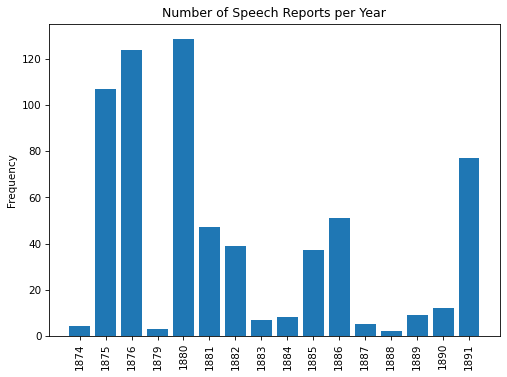

In [2708]:
report_year_counts = year_counts(df_dedup)
years, scores = zip(*report_year_counts)
frequency_visualisation(values=years, frequency=scores, title="Number of Speech Reports per Year")

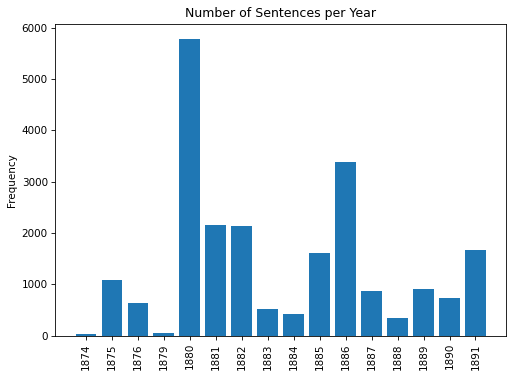

In [2709]:
sentence_year_counts = year_counts(speech_sents_df_dedup)
years, scores = zip(*sentence_year_counts)
frequency_visualisation(values=years, frequency=scores, title="Number of Sentences per Year")

### Keyword Counts

#### Not affected by global text filters, but affected by others

In [2710]:
df_count = dataframe_count_strings(dataframe=df_dedup_non_text_filt, column="text", 
                                   keywords=count_keywords, word_boundary=word_boundary)
df_count 

{'parnell': 1819, 'reform': 61}

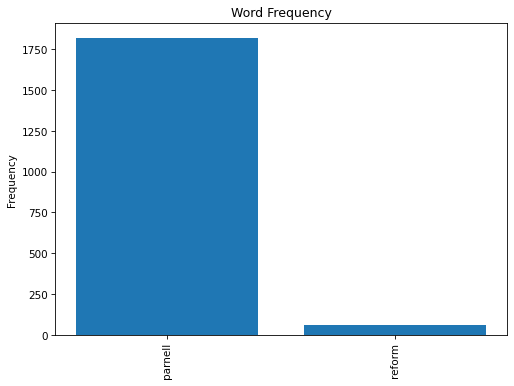

In [2711]:
words, scores = zip(*df_count.items())
frequency_visualisation(values=words, frequency=scores, title="Word Frequency")

### Sentence and Report Co-Frequency Counts

#### Not affected by text filters, but affected by other filters

In [2712]:
co_freq_count = {}
sent_co_freq_count = {}

for count_word in count_keywords:
    #filter the speech_sents_df_dedup dataframe for each word in count_keywords,
    #so that rows where sentence contains word are returned
    sent_word_df = filter_dataframe_by_keywords(dataframe=sents_df_dedup_non_text, column="sentence", 
                                                    keywords=[count_word], word_boundary=word_boundary, 
                                                    match_all=True)
    sent_word_count = dataframe_cooccurrance_count(dataframe=sent_word_df, column="sentence", 
                                              word=count_word)
    
    word_df = filter_dataframe_by_keywords(dataframe=df_dedup_non_text_filt, column="text", 
                                                    keywords=[count_word], word_boundary=word_boundary, 
                                                    match_all=True)
    word_count = dataframe_cooccurrance_count(dataframe=word_df, column="text", 
                                              word=count_word)
    
    
    if stopwords_removal:
        sent_word_count = [(k, v) for k, v in sent_word_count if k not in stopwords_ls]
        word_count = [(k, v) for k, v in word_count if k not in stopwords_ls]
    sent_co_freq_count[count_word] = sent_word_count[:15]
    co_freq_count[count_word] = word_count[:15]

In [2713]:
co_freq_count

{'parnell': [('mr', 3809),
  ('ireland', 3577),
  ('hear', 2660),
  ('irish', 2616),
  ('people', 1800),
  ('right', 1735),
  ('hon', 1719),
  ('land', 1623),
  ('government', 1615),
  ('one', 1422),
  ('question', 1350),
  ('great', 1289),
  ('bill', 1225),
  ('country', 1207),
  ('gentleman', 1206)],
 'reform': [('ireland', 764),
  ('hear', 678),
  ('land', 568),
  ('mr', 538),
  ('irish', 459),
  ('government', 421),
  ('one', 372),
  ('people', 365),
  ('country', 347),
  ('great', 347),
  ('tenants', 289),
  ('question', 254),
  ('act', 254),
  ('right', 234),
  ('present', 221)]}

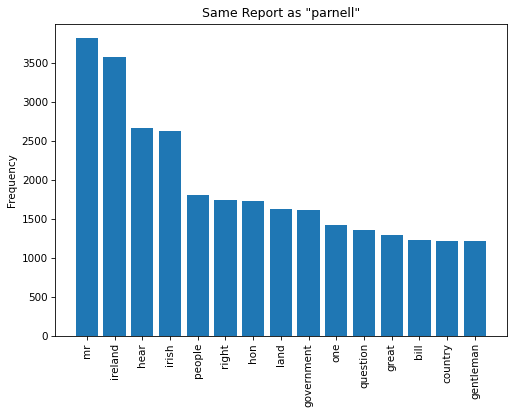

In [2714]:
report_visual_words = co_freq_count[context_visual_keyword]
words, scores = zip(*report_visual_words)
frequency_visualisation(values=words, frequency=scores, title=f'Same Report as "{context_visual_keyword}"')

In [2715]:
sent_co_freq_count

{'parnell': [('mr', 2127),
  ('hon', 326),
  ('ireland', 238),
  ('right', 216),
  ('gentleman', 203),
  ('irish', 198),
  ('member', 173),
  ('government', 145),
  ('question', 137),
  ('one', 136),
  ('whether', 130),
  ('house', 128),
  ('hear', 125),
  ('people', 124),
  ('secretary', 123)],
 'reform': [('land', 35),
  ('great', 21),
  ('ireland', 19),
  ('irish', 15),
  ('shall', 14),
  ('advance', 13),
  ('country', 12),
  ('hear', 12),
  ('measure', 11),
  ('one', 11),
  ('people', 10),
  ('improvements', 10),
  ('question', 9),
  ('present', 9),
  ('party', 8)]}

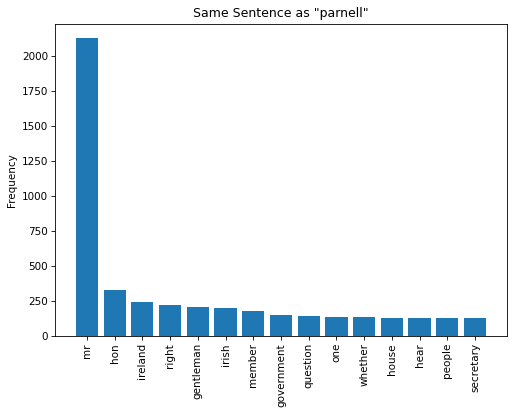

In [2716]:
sentence_visual_words = sent_co_freq_count[context_visual_keyword]
words, scores = zip(*sentence_visual_words)
frequency_visualisation(values=words, frequency=scores, title=f'Same Sentence as "{context_visual_keyword}"')

### Sentence Keywords Context

In [2717]:
sentence_keywords_df = filter_dataframe_by_keywords(dataframe=sents_df_non_text, column="sentence", 
                                                    keywords=context_keywords, word_boundary=word_boundary, 
                                                    match_all=True)

speech_list = sentence_keywords_df['speech_id'].to_list()
report_list = sentence_keywords_df['filename'].to_list()
publication_list = sentence_keywords_df['publication'].to_list()
location_list = sentence_keywords_df['place'].to_list()
date_list = sentence_keywords_df['date'].to_list()
sentence_list = sentence_keywords_df['sentence'].to_list()

for speech, place, report, pub, date, sent in zip(speech_list, location_list, 
                                                   report_list, publication_list, date_list, sentence_list):
    print(report, pub, speech, place, date)
    print(sent)
    print('\n')

parnell_source_00005 the freeman's journal speech_00002 dublin, ireland 1875-01-21 00:00:00
mr charles stewart parnell in seconding the resolution said that as a landlord and also as a tenant farmer he could claim to take a double interest in this important question applause


parnell_source_00010 the drogheda argus speech_00004 navan, ireland 1875-04-12 00:00:00
with reference to the question of home rule mr parnell said that since he first could think he had the principles of that movement ever fixed in his heart for he always believed the day would come when the voice of the people in this country would rule her affairs and make her laws and that was what he understood by home rule applause


parnell_source_00011 the freeman's journal speech_00004 navan, ireland 1875-04-12 00:00:00
with reference to the question of home rule mr parnell said that since he first could think he had the principles of that movement ever fixed in his heart for he always believed the day would come when th

### Report Keywords Context

In [2718]:
report_keywords_df = filter_dataframe_by_keywords(dataframe=df_all_non_text_filt, column="text", 
                                                    keywords=context_keywords, word_boundary=word_boundary, 
                                                    match_all=True)

speech_list = report_keywords_df['speech_id'].to_list()
report_list = report_keywords_df['filename'].to_list()
publication_list = report_keywords_df['publication'].to_list()
location_list = report_keywords_df['place'].to_list()
date_list = report_keywords_df['date'].to_list()
text_list = report_keywords_df['text'].to_list()

for speech, place, report, pub, date, text in zip(speech_list, location_list, 
                                                   report_list, publication_list, date_list, text_list):
    print(report, pub, speech, place, date)
    print(text)
    print('\n')

parnell_source_00001 the nation speech_00001 dublin, ireland 1874-07-11 00:00:00
the home rule league great meeting in the rotundo great speech of mr butt on saturday a meeting of the home rule league was held in the round room of the rotundo there was an immense attendance the platform the gallery for admission to which a charge was mad and body of the hall having been literally thronged with a most respectable and enthusiastic audience mr charles stewart parnell high sheriff of wicklow occupied the chair and amongst those on the platform were mr butt m p mr meldon m p mr a m sullivan m p mr fay m p dr o'leary m p and the hon judge little all of whom were enthusiastically received the following report of the proceedings is taken somewhat abridged from the freeman at half past eight o'clock on the motion of mr alfred webb the chair was taken amidst loud cheers by mr c s parnell the chairman who was received with loud and prolonged applause said ladies and gentlemen i thank you for the 

## Network Analysis

In [2719]:
edges = df_all_text_filt[['publication', 'place']].values.tolist()
network_graph(edges, edge_weights=True)

:Graph   [start,end]   (weight,edge_line_width)

## Topic Modelling

In [2720]:
#initialize BERTopic topic model with parameters, uses a sentence transformers model to calculate topics
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", nr_topics="auto", top_n_words=15, min_topic_size=15)

In [2721]:
topic_model_df = sents_df_dedup_text_filt.copy()
if stopwords_removal:
    topic_model_df['sentence'] = topic_model_df['sentence'].apply(lambda x: remove_stopwords(x, stopwords_ls))

In [2722]:
topics_data_all = bertopic_topics(topic_model_df, topic_model)
model_data = topics_data_all[2]

### Topics List

In [2723]:
model_data.get_topics()

{-1: [('ireland', 0.008698548618238816),
  ('irish', 0.007864197191641846),
  ('people', 0.007528638503144455),
  ('government', 0.006645515707258532),
  ('country', 0.006264871278166044),
  ('hear', 0.006242999042528995),
  ('land', 0.006239097720042929),
  ('one', 0.006172488052573352),
  ('great', 0.006134727846204865),
  ('question', 0.005668696011347081),
  ('bill', 0.005664574638798274),
  ('right', 0.005657571963234074),
  ('house', 0.005589911166535923),
  ('english', 0.005424120847628663),
  ('hon', 0.005383848150867433)],
 0: [('parnell', 0.014214025277273126),
  ('mr', 0.012543900719081832),
  ('ireland', 0.007994049383819965),
  ('hon', 0.007423408161608201),
  ('irish', 0.007289389957349019),
  ('right', 0.007207155040021211),
  ('gentleman', 0.006832416649510534),
  ('tenants', 0.006573849468902884),
  ('land', 0.006374018041197181),
  ('question', 0.006168881368329798),
  ('landlords', 0.006029532377003662),
  ('government', 0.00594061989313207),
  ('act', 0.005735824774

### Clustering Groups

In [2724]:
model_data.visualize_hierarchy()

### Topics over Time

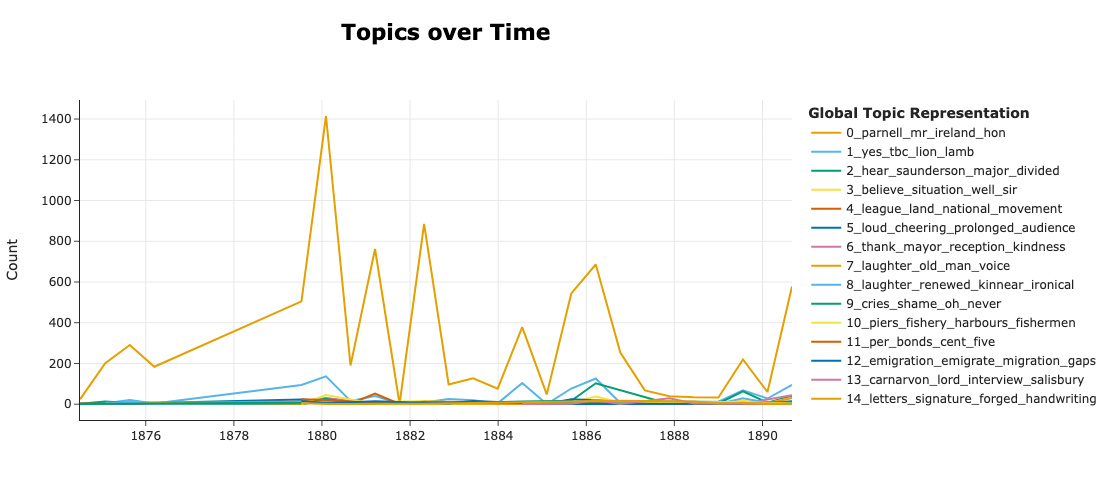

In [2725]:
model_time = bertopic_time(topic_model_df, model_data)
model_time